# EONIA curve bootstrapping

**The Euro Overnight Index Average (Eonia) is the average overnight reference rate for which European banks lend to one another in euros.**

In [1]:
import QuantLib as ql 
import matplotlib.pyplot as plt 
from datetime import date
import pandas as pd 

plt.style.use('bmh')

In [2]:
# set calculation date
calc_date = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = calc_date

In [3]:
# The first three instruments are 
# three 1-day deposit that give us 
# discounting between today and the day after spot.

# number of fixing days going from 
# 0 (for the deposit starting today) to 
# 2 (for the deposit starting on the spot date)

helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(1, ql.Days),
                         fixingDays,
                         ql.TARGET(),
                         ql.Following,
                         False,
                         ql.Actual360())
    for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
]

**OISRateHelper**<br>
**DatedOISRateHelper**<br>
Rate helper for bootstrapping over Overnight Indexed Swap rates.

In [4]:
# series of OIS quotes for the first month

eonia = ql.Eonia()

helpers += [
    ql.OISRateHelper(2,
                     ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                     eonia)
    for rate, tenor in [(0.070, (1,ql.Weeks)), 
                        (0.069, (2,ql.Weeks)), 
                        (0.078, (3,ql.Weeks)), 
                        (0.074, (1,ql.Months))]
]

In [5]:
# five OIS forwards on ECB dates
# specify start and end dates explicitly --> need DatedOISRateHelper

helpers += [
    ql.DatedOISRateHelper(start_date,
                          end_date,
                          ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                          eonia)
                                        # rate   # start_date                 # end_date
    for rate, start_date, end_date in [( 0.046, ql.Date(16,ql.January,2013), ql.Date(13,ql.February,2013)),
                                       ( 0.016, ql.Date(13,ql.February,2013), ql.Date(13,ql.March,2013)),
                                       (-0.007, ql.Date(13,ql.March,2013), ql.Date(10,ql.April,2013)),
                                       (-0.013, ql.Date(10,ql.April,2013), ql.Date(8,ql.May,2013)),
                                       (-0.014, ql.Date(8,ql.May,2013), ql.Date(12,ql.June,2013))]
]

In [6]:
# add OIS quotes up to 30 years.

helpers += [
    ql.OISRateHelper(2,
                     ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                     eonia)
    
    for rate, tenor in [(0.002, (15,ql.Months)), 
                        (0.008, (18,ql.Months)),
                        (0.021, (21,ql.Months)), 
                        (0.036, (2,ql.Years)),
                        (0.127, (3,ql.Years)), 
                        (0.274, (4,ql.Years)),
                        (0.456, (5,ql.Years)), 
                        (0.647, (6,ql.Years)),
                        (0.827, (7,ql.Years)), 
                        (0.996, (8,ql.Years)),
                        (1.147, (9,ql.Years)), 
                        (1.280, (10,ql.Years)),
                        (1.404, (11,ql.Years)), 
                        (1.516, (12,ql.Years)),
                        (1.764, (15,ql.Years)), 
                        (1.939, (20,ql.Years)),
                        (2.003, (25,ql.Years)), 
                        (2.038, (30,ql.Years))]
]

In [7]:
eonia_curve = ql.PiecewiseLogCubicDiscount(0,
                                           ql.TARGET(),
                                           helpers,
                                           ql.Actual365Fixed())

In [8]:
eonia_curve.enableExtrapolation()

In [9]:
today = eonia_curve.referenceDate()
end = today + ql.Period(2, ql.Years)

In [10]:
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber())]

In [11]:
rates = [
    eonia_curve.forwardRate(d,
                            ql.TARGET().advance(d, 1, ql.Days),
                            ql.Actual360(),
                            ql.Simple).rate()
    for d in dates
]

In [12]:
eonia_curve_df = pd.DataFrame(data={'Date':dates, 'Curve':rates})
eonia_curve_df

,Date,Curve
0,"December 11th, 2012",0.000400
1,"December 12th, 2012",0.000400
2,"December 13th, 2012",0.000400
3,"December 14th, 2012",0.000672
4,"December 15th, 2012",0.000737
...,...,...
725,"December 6th, 2014",0.001609
726,"December 7th, 2014",0.001612
727,"December 8th, 2014",0.001618
728,"December 9th, 2014",0.001624


In [13]:
# convert QuantLib.Date to python date

def to_datetime(d):
    return date(d.year(), d.month(), d.dayOfMonth())

In [14]:
# convert QuantLib.Date to pd.datetime

eonia_curve_df['Date'] = pd.to_datetime(eonia_curve_df.Date.apply(to_datetime))

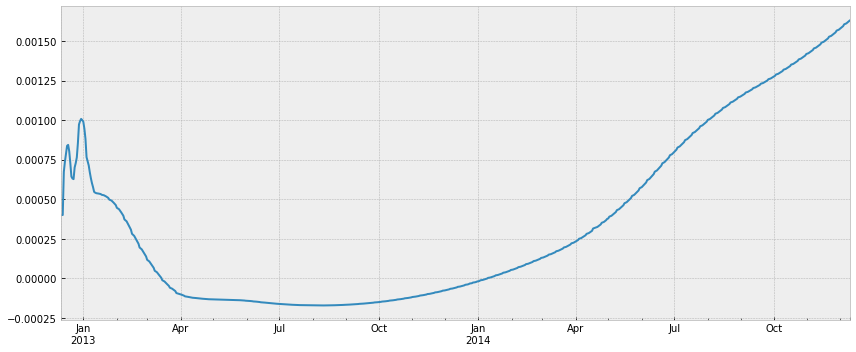

In [15]:
eonia_curve_df.plot('Date', 'Curve', figsize=(12,5), legend=False, xlabel='')
plt.tight_layout()
plt.show()